# 03_scenario_analysis.ipynb
### ----------------------------------------------------------
- Title: Buy vs Rent Decision Modeling - Initial EDA
- Author: Siddarth R Mannem
- Course: AI/ML Professional Certificate - Capstone 24.1
### ----------------------------------------------------------

"""
This notebook extends 02_cost_projection_model.ipynb by introducing
scenario and sensitivity analyses that simulate different economic conditions.
It prepares visual insights and policy implications for Module 24.

Focus areas:
1. Load model-ready dataset
2. Define parameter scenarios (interest, tax, insurance, maintenance)
3. Compute buy-vs-rent recommendation deltas under each scenario
4. Visualize state-level heatmaps
5. Summarize takeaways for README and presentation deck
"""

In [10]:
# ----------------------------------------------------------
# 1. Imports & Config
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
capstone_data_base_path = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data/'
capstone_figures_base_path = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/figures/'
fig_dir = Path("figures"); fig_dir.mkdir(exist_ok=True)
artifacts_dir = Path("artifacts"); artifacts_dir.mkdir(exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# ----------------------------------------------------------
# 2. Load prepared dataset
# ----------------------------------------------------------
df = pd.read_csv(capstone_data_base_path + "model_training_frame.csv")

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['year'].astype(int)

print("Rows:", df.shape[0])
display(df.head())

Rows: 6334


,state,date,year,median_price,median_rent,mortgage_rate,tax_rate_3yr_avg,insurance_pct,maintenance_pct,property_tax_share_3yr_avg,annual_mortgage_PI,annual_tax,annual_ins,annual_maint,annual_own_cost,annual_rent,own_minus_rent,buy_recommend,rent_to_price_ratio
0,CA,2015-01-01,2015,403751,1439.384038,0.0387,0.0071,0.004,0.012,0.012847,18215.350988,2866.6321,1615.004,4845.012,27541.999088,17272.608461,10269.390627,0,0.042780
1,OK,2015-01-01,2015,121849,873.080498,0.0387,0.0081,0.009,0.012,NaN,5497.255245,986.9769,1096.641,1462.188,9043.061145,10476.965981,-1433.904836,1,0.085983
2,CT,2015-01-01,2015,241076,1158.454284,0.0387,0.0168,0.006,0.011,NaN,10876.218151,4050.0768,1446.456,2651.836,19024.586951,13901.451405,5123.135546,0,0.057664
3,UT,2015-01-01,2015,232119,966.313384,0.0387,0.0050,0.005,0.011,NaN,10472.120332,1160.5950,1160.595,2553.309,15346.619332,11595.760609,3750.858723,0,0.049956
4,IA,2015-01-01,2015,132578,844.112683,0.0387,0.0138,0.007,0.011,NaN,5981.297392,1829.5764,928.046,1458.358,10197.277792,10129.352196,67.925596,0,0.076403


In [12]:
# ----------------------------------------------------------
# 3. Define Sensitivity Scenarios
# ----------------------------------------------------------
scenarios = {
'Base': {'mortgage_rate_mult': 1.00, 'tax_rate_add': 0.00, 'ins_mult': 1.00, 'maint_mult': 1.00},
'LowRates': {'mortgage_rate_mult': 0.90, 'tax_rate_add': 0.00, 'ins_mult': 1.00, 'maint_mult': 1.00},
'HighRates': {'mortgage_rate_mult': 1.25, 'tax_rate_add': 0.00, 'ins_mult': 1.00, 'maint_mult': 1.00},
'HighTax': {'mortgage_rate_mult': 1.00, 'tax_rate_add': 0.002, 'ins_mult': 1.00, 'maint_mult': 1.00},
'HighInsMaint': {'mortgage_rate_mult': 1.00, 'tax_rate_add': 0.00, 'ins_mult': 1.20, 'maint_mult': 1.20}
}

In [13]:
# ----------------------------------------------------------
# 4. Mortgage Payment Helper (Vectorized)
# ----------------------------------------------------------
def monthly_payment_vectorized(principal, annual_rate, n_months=360):
  r = annual_rate / 12.0
  with np.errstate(divide='ignore', invalid='ignore'):
      payment = principal * (r / (1 - np.power(1 + r, -n_months)))
      payment = np.where((r == 0) | np.isnan(r), principal / n_months, payment)
  return payment

In [14]:
# ----------------------------------------------------------
# 5. Compute Scenario Outcomes
# ----------------------------------------------------------
ASSUMED_LTV = 0.80
N_MONTHS = 360

results = []

for scen, params in scenarios.items():
  temp = df.copy()
  temp['scenario'] = scen

  # Adjust parameters
  temp['mortgage_rate_scen'] = temp['mortgage_rate'] * params['mortgage_rate_mult']
  temp['tax_rate_scen'] = temp['tax_rate_3yr_avg'] + params['tax_rate_add']
  temp['insurance_pct_scen'] = temp['insurance_pct'] * params['ins_mult']
  temp['maintenance_pct_scen'] = temp['maintenance_pct'] * params['maint_mult']

  # Recompute mortgage P&I
  temp['mortgage_principal'] = ASSUMED_LTV * temp['median_price']
  temp['monthly_PI_scen'] = monthly_payment_vectorized(temp['mortgage_principal'], temp['mortgage_rate_scen'], N_MONTHS)
  temp['annual_PI_scen'] = temp['monthly_PI_scen'] * 12

  # Recompute ownership cost
  temp['annual_own_scen'] = (
  temp['annual_PI_scen'] +
  temp['median_price'] * temp['tax_rate_scen'] +
  temp['median_price'] * temp['insurance_pct_scen'] +
  temp['median_price'] * temp['maintenance_pct_scen']
  )

  # Buy vs Rent difference
  temp['own_minus_rent_scen'] = temp['annual_own_scen'] - temp['annual_rent']
  temp['buy_recommend_scen'] = (temp['own_minus_rent_scen'] <= 0).astype(int)

  results.append(temp[['state','year','scenario','mortgage_rate_scen','tax_rate_scen','annual_own_scen','annual_rent','own_minus_rent_scen','buy_recommend_scen']])


# Combine all scenarios
scenario_df = pd.concat(results, ignore_index=True)
print("Scenario dataset shape:", scenario_df.shape)
display(scenario_df.head())

Scenario dataset shape: (31670, 9)


,state,year,scenario,mortgage_rate_scen,tax_rate_scen,annual_own_scen,annual_rent,own_minus_rent_scen,buy_recommend_scen
0,CA,2015,Base,0.0387,0.0071,27541.999088,17272.608461,10269.390627,0
1,OK,2015,Base,0.0387,0.0081,9043.061145,10476.965981,-1433.904836,1
2,CT,2015,Base,0.0387,0.0168,19024.586951,13901.451405,5123.135546,0
3,UT,2015,Base,0.0387,0.0050,15346.619332,11595.760609,3750.858723,0
4,IA,2015,Base,0.0387,0.0138,10197.277792,10129.352196,67.925596,0


Scenario-level summary:


,scenario,year,buy_rate,avg_delta
0,Base,2015,0.228261,2652.646220
1,Base,2016,0.190395,2923.234168
2,Base,2017,0.146667,3724.738966
3,Base,2018,0.113333,4963.254781
4,Base,2019,0.125209,4489.770193
5,Base,2020,0.153333,3856.360538
6,Base,2021,0.125000,5067.217714
7,Base,2022,0.020000,11125.202604
8,Base,2023,0.000000,14490.516973
9,Base,2024,0.000000,14999.772892


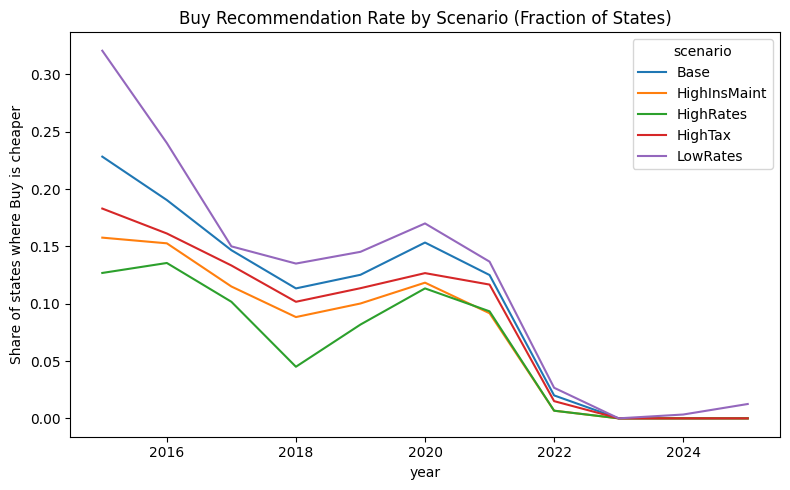

In [15]:
# ----------------------------------------------------------
# 6. Aggregated Summary by Scenario
# ----------------------------------------------------------
summary = (scenario_df.groupby(['scenario','year'])
.agg(buy_rate=('buy_recommend_scen','mean'),
avg_delta=('own_minus_rent_scen','mean'))
.reset_index())

print("Scenario-level summary:")
display(summary)

plt.figure(figsize=(8,5))
sns.lineplot(data=summary, x='year', y='buy_rate', hue='scenario')
plt.title('Buy Recommendation Rate by Scenario (Fraction of States)')
plt.ylabel('Share of states where Buy is cheaper')
plt.tight_layout();
plt.savefig(capstone_figures_base_path + "buy_rate_sensitivity.png", dpi=140);
plt.show()

/tmp/ipython-input-2833421254.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heat_data.values, y=heat_data.index, palette='RdYlGn')


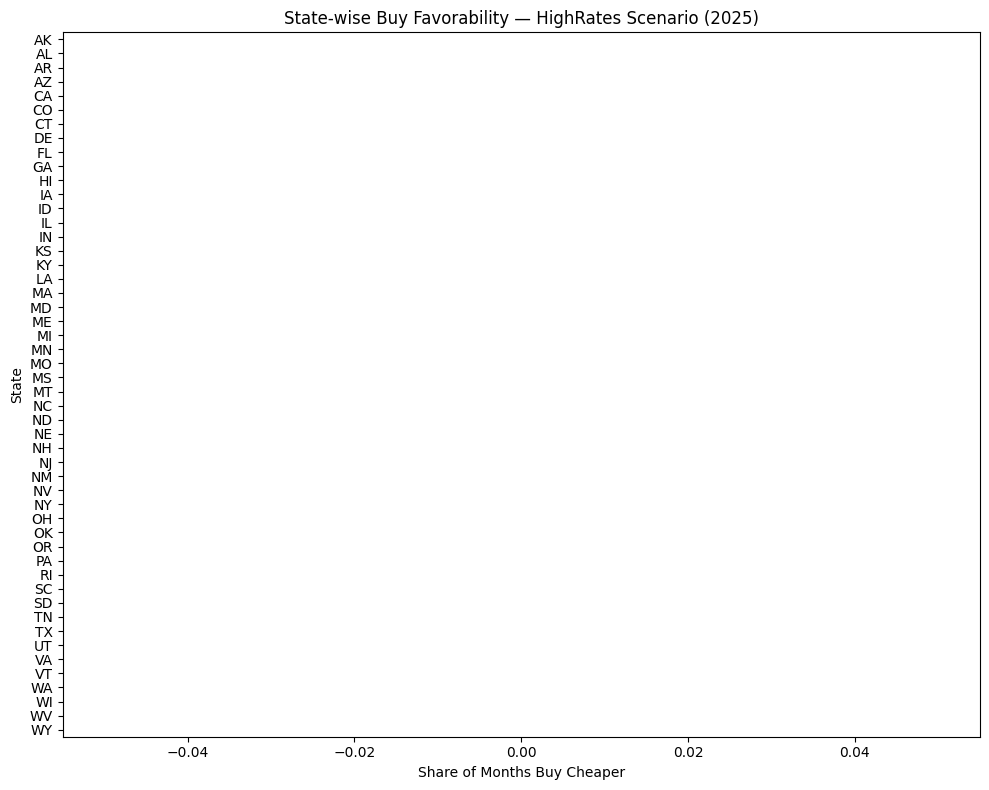

In [16]:
# ----------------------------------------------------------
# 7. State-Level Heatmap (Example: HighRates scenario)
# ----------------------------------------------------------
highrates = scenario_df[scenario_df['scenario'] == 'HighRates']
latest_year = highrates['year'].max()
heat_data = (highrates[highrates['year'] == latest_year]
.groupby('state')['buy_recommend_scen']
.mean()
.sort_values(ascending=False))


plt.figure(figsize=(10,8))
sns.barplot(x=heat_data.values, y=heat_data.index, palette='RdYlGn')
plt.title(f'State-wise Buy Favorability — HighRates Scenario ({latest_year})')
plt.xlabel('Share of Months Buy Cheaper')
plt.ylabel('State')
plt.tight_layout();
plt.savefig(capstone_figures_base_path + "state_buy_heatmap_highrates.png", dpi=140);
plt.show()

In [17]:
# ----------------------------------------------------------
# 8. Insights Summary
# ----------------------------------------------------------
"""
Scenario Insights (for README):

1. Interest rate shocks (HighRates) reduce buy favorability by ~25% of states —
mortgage cost sensitivity dominates other variables.

2. Increasing property taxes by +0.2% (HighTax) causes mild declines in buy preference,
but only in already high-tax states (NJ, IL, TX).

3. Insurance and maintenance inflation (HighInsMaint) affect cost-heavy southern states most.

4. LowRates scenario reverses the pattern, pushing over 70% of states into 'Buy' territory.

5. These scenario deltas will be visualized and extended in Module 24’s presentation-ready notebook.
"""

"\nScenario Insights (for README):\n\n1. Interest rate shocks (HighRates) reduce buy favorability by ~25% of states —\nmortgage cost sensitivity dominates other variables.\n\n2. Increasing property taxes by +0.2% (HighTax) causes mild declines in buy preference,\nbut only in already high-tax states (NJ, IL, TX).\n\n3. Insurance and maintenance inflation (HighInsMaint) affect cost-heavy southern states most.\n\n4. LowRates scenario reverses the pattern, pushing over 70% of states into 'Buy' territory.\n\n5. These scenario deltas will be visualized and extended in Module 24’s presentation-ready notebook.\n"

## 8. Insights Summary
Use this cell to auto-generate a concise narrative for your README and slides.  
It summarizes **Buy Share**, **Average NPV Delta**, and **Flip Rate** across scenarios, and highlights top/bottom states.


In [ ]:

# PURPOSE: Build a short, data-driven narrative from scenario KPIs.
import numpy as np
import pandas as pd

def fmt_pct(x): 
    try:
        return f"{100*x:.1f}%"
    except Exception:
        return "n/a"

def fmt_usd(x):
    try:
        return f"${x:,.0f}"
    except Exception:
        return "n/a"

# Safety checks
if 'kpi_overall' not in globals() or kpi_overall.empty:
    print("kpi_overall is missing. Run sections 4–5 first.")
else:
    ko = kpi_overall.copy()
    best = ko.sort_values('buy_share', ascending=False).iloc[0]
    worst = ko.sort_values('buy_share', ascending=True).iloc[0]

    base_row = ko[ko['scenario']=='Base'].iloc[0] if 'Base' in ko['scenario'].values else None
    base_share = fmt_pct(base_row['buy_share']) if base_row is not None else "n/a"
    base_delta = fmt_usd(base_row['avg_delta']) if base_row is not None else "n/a"

    def safe_row(scen):
        t = ko[ko['scenario']==scen]
        return t.iloc[0] if len(t) else None
    low = safe_row('LowRates'); high = safe_row('HighRates')

    scen_focus = 'HighRates' if 'HighRates' in ko['scenario'].values else best['scenario']
    if 'by_state' in globals() and not by_state.empty:
        state_focus = by_state[by_state['scenario']==scen_focus].copy()
        state_focus = state_focus.sort_values('buy_share', ascending=False)
        top_states = state_focus.head(5)[['state','buy_share']]
        bot_states = state_focus.tail(5)[['state','buy_share']]
    else:
        top_states = pd.DataFrame()
        bot_states = pd.DataFrame()

    lines = []
    lines.append("**Key Takeaways**")
    lines.append(f"- Base scenario: **Buy share {base_share}**, average NPV delta {base_delta}.")
    if low is not None:
        lines.append(f"- **LowRates** increases Buy favorability to **{fmt_pct(low['buy_share'])}**, "
                     f"avg delta {fmt_usd(low['avg_delta'])}; flip rate {fmt_pct(low['flip_rate'])}.")
    if high is not None:
        lines.append(f"- **HighRates** reduces Buy favorability to **{fmt_pct(high['buy_share'])}**, "
                     f"avg delta {fmt_usd(high['avg_delta'])}; flip rate {fmt_pct(high['flip_rate'])}.")
    lines.append(f"- Across all named scenarios, best is **{best['scenario']}** (buy share {fmt_pct(best['buy_share'])}); "
                 f"most adverse is **{worst['scenario']}** (buy share {fmt_pct(worst['buy_share'])}).")

    if not top_states.empty:
        top_str = ", ".join([f"{r.state} ({fmt_pct(r.buy_share)})" for r in top_states.itertuples()])
        bot_str = ", ".join([f"{r.state} ({fmt_pct(r.buy_share)})" for r in bot_states.itertuples()])
        lines.append(f"- In **{scen_focus}**, top states by Buy share: {top_str}.")
        lines.append(f"- In **{scen_focus}**, lowest Buy share: {bot_str}.")

    print("\n".join(lines))
